<a href="https://colab.research.google.com/github/yuzhenke1122/video_view_analysis_n_prediction/blob/main/Amazon_Prime_Video_View_Time_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0. Load Packages and Data

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Shared link from my google drive
# https://drive.google.com/file/d/1BLYtnPH_pkcIaRw_DaWHrrXyxivMUi10/view?usp=sharing

id = "1BLYtnPH_pkcIaRw_DaWHrrXyxivMUi10"
file = drive.CreateFile({'id':id})
file.GetContentFile('TVdata.txt')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

In [ ]:
# Import dataset as TV_file
TV_file = pd.read_csv('TVdata.txt')

# Rename the column 'weighted_horizontal_position'
TV_file.rename(columns = {'weighted_horizontal_poition':'weighted_horizontal_position'}, inplace = True)

# Check the first 10 rows
TV_file.head(10)

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.60561,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.50000,112.30102,51,other award,PG-13,1.71000
1,300175,270338.42637,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.50000,94.98325,41,no award,R,3.25000
2,361899,256165.86745,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.30000,115.76367,58,other award,R,2.64667
3,308314,196622.72100,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.60000,130.70358,94,Oscar,R,1.66667
4,307201,159841.65206,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.40000,105.54553,37,other award,R,3.06667
5,389496,135076.60975,1,5,mgm,2000,Comedy,13250,60000000,32095318,5.50000,98.46835,37,no award,PG-13,2.75000
6,385507,134155.74020,1,6,lionsgate,2013,"Action,Adventure,Thriller",16188,11000000,8551228,5.20000,94.33642,57,other award,R,2.74000
7,380517,116906.00792,1,7,lionsgate,2014,"Western,Drama",24321,16000000,2428883,6.60000,123.30252,68,other award,R,3.00278
8,369857,116871.12162,2,9,lionsgate,2013,"Thriller,Crime,Western",119679,45000000,12026670,6.40000,107.21283,54,other award,R,1.82222
9,393463,111565.59675,2,7,lionsgate,2009,"Action,Adventure,Sci-Fi,Fantasy,Thriller",0,0,0,0.00000,94.74845,0,other award,R,2.07963


# Part 1. Data Exploration

## 1.1 Overview of the Dataset

In [ ]:
TV_file.shape

(4226, 16)

There are 4226 rows and 16 columns in this data file.

In [ ]:
TV_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_position   4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   int64  
 8   budget                         4226 non-null   int64  
 9   boxoffice                      4226 non-null   int64  
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   i

There are 8 integer variables, 4 float variables, and 4 objects. It seems that there is no Null value in this data, but we need further investigation on whether it has missing values.

In [ ]:
TV_file.drop(columns = ['video_id']).describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.95])

,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000
mean,4218.63024,7.78254,28.10364,2001.05679,6462.92404,2150743.43942,2536338.47160,5.25710,89.55612,15.97373,0.95465
std,13036.07996,6.13418,11.86365,17.49685,31596.00679,7176604.48302,8243516.26593,2.12281,21.08618,26.20522,0.95505
min,2.18762,1.00000,1.00000,1916.00000,0.00000,0.00000,0.00000,0.00000,4.03725,0.00000,0.00000
10%,141.98491,3.00000,13.00000,1974.00000,8.00000,0.00000,0.00000,2.30000,62.39078,0.00000,0.00000
25%,351.16878,4.00000,20.00000,1998.00000,81.00000,0.00000,0.00000,4.30000,82.60171,0.00000,0.00000
50%,1193.49999,6.00000,28.00000,2008.00000,535.00000,0.00000,0.00000,5.80000,90.73031,0.00000,1.00000
75%,3356.78882,9.00000,36.00000,2012.00000,3053.00000,1500000.00000,0.00000,6.80000,99.50031,41.00000,1.66667
95%,14692.83393,22.00000,48.00000,2015.00000,26199.50000,12000000.00000,8551228.00000,7.80000,119.13118,65.00000,2.59722
max,307127.60561,41.00000,70.00000,2017.00000,948630.00000,107000000.00000,184208848.00000,10.00000,246.01677,100.00000,4.00000


In the percentile table above, only integer and float variables are presented; objects (or string variables) such as 'genres' are excluded. Because 'video_id' does not contain any useful information for percentile analysis, it is also excluded. Notice that 'budget', 'boxoffice', 'metacritic_score' and 'star_category' columns have lots of 0 in lower percentiles, which causes the distributions very skewed. The excessive 0 values may indicate missing values, and further investigation is needed.

In [ ]:
# Check the unique values for each column
TV_file.nunique()

video_id                         4226
cvt_per_day                      4226
weighted_categorical_position      37
weighted_horizontal_position       68
import_id                           4
release_year                       97
genres                           1165
imdb_votes                       2282
budget                            253
boxoffice                         410
imdb_rating                        85
duration_in_mins                 4097
metacritic_score                   90
awards                              5
mpaa                                6
star_category                     630
dtype: int64

From the result above, we can see that both variables, video_id and cvt_per_dat, have 4226 unique values, which indicate that there are no duplicates in these two columns.

In [ ]:
# Double check wheather there are duplicates in video_id column
if TV_file['video_id'].duplicated().sum() == 0:
  print("There is no duplicate in 'video_id' column.")
if TV_file['cvt_per_day'].duplicated().sum() == 0:
  print("There is no duplicate in 'cvt_per_day' column.")

There is no duplicate in 'video_id' column.
There is no duplicate in 'cvt_per_day' column.


Therefore, we can conclude that there are no duplicates in this dataset.

## 1.2 Explore the Numerical Features

### 1.2.1 Correlation Among Numerical Features

In [ ]:
# Subset of numerical features
num_ft = TV_file[['cvt_per_day', 'weighted_categorical_position', 'weighted_horizontal_position', 
          'release_year', 'imdb_votes', 'budget', 'boxoffice', 'imdb_rating',
          'duration_in_mins', 'metacritic_score', 'star_category']]

num_ft.head(10)

NameError: ignored

In [ ]:
corr = num_ft.corr()
# Check the correlation matrix
corr

,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.00000,-0.14800,-0.30166,0.04586,0.29770,0.31589,0.31221,0.05889,0.15222,0.24916,0.24696
weighted_categorical_position,-0.14800,1.00000,-0.08407,-0.06890,-0.06370,-0.08990,-0.07363,-0.11644,-0.17446,-0.04432,-0.12285
weighted_horizontal_position,-0.30166,-0.08407,1.00000,0.02663,-0.22075,-0.21136,-0.24471,-0.16202,-0.10234,-0.25502,-0.16780
release_year,0.04586,-0.06890,0.02663,1.00000,-0.08266,-0.04012,-0.12809,-0.19886,-0.09681,-0.16704,-0.19845
imdb_votes,0.29770,-0.06370,-0.22075,-0.08266,1.00000,0.27285,0.53147,0.16326,0.15567,0.32186,0.22519
budget,0.31589,-0.08990,-0.21136,-0.04012,0.27285,1.00000,0.50462,0.10567,0.25134,0.31461,0.32172
boxoffice,0.31221,-0.07363,-0.24471,-0.12809,0.53147,0.50462,1.00000,0.16367,0.22618,0.46496,0.32233
imdb_rating,0.05889,-0.11644,-0.16202,-0.19886,0.16326,0.10567,0.16367,1.00000,0.34405,0.34693,0.19177
duration_in_mins,0.15222,-0.17446,-0.10234,-0.09681,0.15567,0.25134,0.22618,0.34405,1.00000,0.32705,0.30911
metacritic_score,0.24916,-0.04432,-0.25502,-0.16704,0.32186,0.31461,0.46496,0.34693,0.32705,1.00000,0.45245


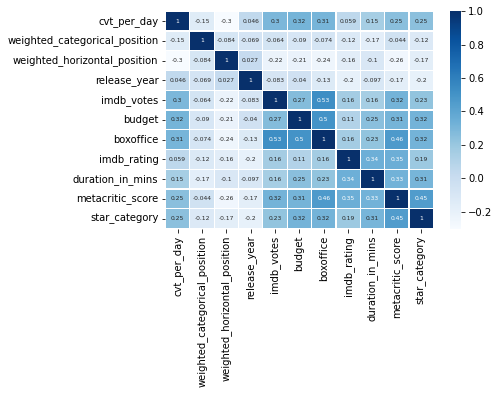

In [ ]:
sns.heatmap(corr, cmap = 'Blues', annot = True, annot_kws = {"size": 6}, linewidths=.3)

The matrix of correlation and heatmap above do not present any high correlaiton between variables as the absolute correlation values are smaller than 0.80, which indicate that there are no highly correlated relationship among these numerical variables. 

### 1.2.2 Graphs of Important Numerical Features 

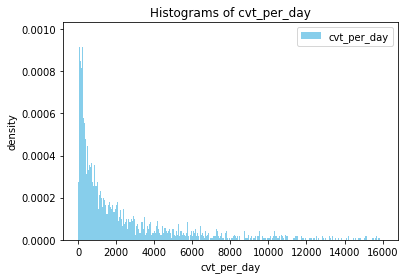

In [ ]:
# cvt_per_day
plt.hist(TV_file['cvt_per_day'], bins = range(0, 16000, 30), color = 'skyblue', label = 'cvt_per_day', density = True)
plt.title('Histograms of cvt_per_day')
plt.legend(loc = 'upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

The left-skewed density of 'cvt_per_day' shows that most of the data points are under 2000

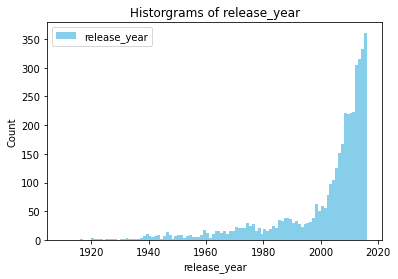

In [ ]:
plt.hist(num_ft['release_year'].values, bins = range(1910, 2017, 1), color='skyblue', label = 'release_year')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year')
plt.xlabel('release_year')
plt.ylabel('Count')
plt.show()


The histogram of 'release_year' is right-skewed, which is expected because the production of movies explodes based on the advantages of modern technologies. However, since the popularity of a video will decrease over time, the 'release_year' can be bucketed based on the 'release_year' range.

### 1.2.3 Explore Suspicious 0 Values

In [ ]:
print("=== Counts of 0 Value in Each Column ===")
print((TV_file == 0).sum(axis = 0))
print(" ")
print("=== Percentages of 0 Value in Each Column ===")
print((TV_file == 0).sum(axis = 0)/TV_file.shape[0]*100)

=== Counts of 0 Value in Each Column ===
video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_position        0
import_id                           0
release_year                        0
genres                              0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
awards                              0
mpaa                                0
star_category                    1846
dtype: int64
 
=== Percentages of 0 Value in Each Column ===
video_id                         0.00000
cvt_per_day                      0.00000
weighted_categorical_position    0.00000
weighted_horizontal_position     0.00000
import_id                        0.00000
release_year                     0.00000
genres                           0.00000
imd

The two tables above present that 6 variables have 0 values, and 3 of these columns have more than 50% of 0 values. Also, 'boxoffice' and 'metacritic_socre' columns may have possible excessive 0 values as the percentages are greater than 70%.

## 1.3 Explore the Categorical Variables

In [ ]:
# Subset of categorical variables
cat_ft = TV_file[['cvt_per_day', 'import_id', 'genres', 'awards', 'mpaa']]

cat_ft.head(10)

,cvt_per_day,import_id,genres,awards,mpaa
0,307127.60561,lionsgate,"Action,Thriller,Drama",other award,PG-13
1,270338.42637,lionsgate,"Comedy,Crime,Thriller",no award,R
2,256165.86745,other,"Crime,Drama",other award,R
3,196622.72100,lionsgate,"Thriller,Drama,War,Documentary,Mystery,Action",Oscar,R
4,159841.65206,lionsgate,"Crime,Thriller,Mystery,Documentary",other award,R
5,135076.60975,mgm,Comedy,no award,PG-13
6,134155.74020,lionsgate,"Action,Adventure,Thriller",other award,R
7,116906.00792,lionsgate,"Western,Drama",other award,R
8,116871.12162,lionsgate,"Thriller,Crime,Western",other award,R
9,111565.59675,lionsgate,"Action,Adventure,Sci-Fi,Fantasy,Thriller",other award,R


The subset of data shown above presents that one data point has only one sub-type in 'import_id', 'awards', and 'mpaa' categorical variables, but it can have muptiple sub-types in 'genres'. For example, a movie can be not rated or can be rated by MAPP (the Motion Picture Association of America) as only one of the following: G, PG, PG-13, R, or NC-17. But it can have multiple sub-types (or, tags) as it can be both Drama and Action. Therefore, we can check the 'import_id', 'awards', and 'mpaa' variables first.

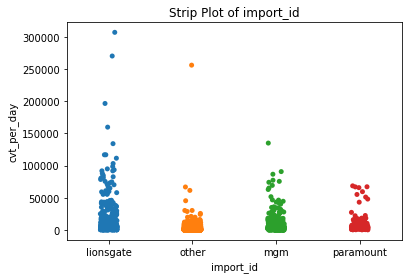

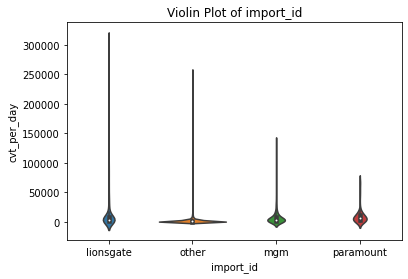

Counts of Each Sub-ype in import_id
other        2963
lionsgate     677
mgm           445
paramount     141
Name: import_id, dtype: int64
Percentages of Each Sub-type in import_id
other       0.70114
lionsgate   0.16020
mgm         0.10530
paramount   0.03336
Name: import_id, dtype: float64


In [ ]:
# Check for import_id
sns.stripplot(x = 'import_id', y = 'cvt_per_day', data = cat_ft, jitter = True)
plt.title("Strip Plot of import_id")
plt.show()

print(" ")

sns.violinplot(x = 'import_id', y = 'cvt_per_day', data = cat_ft)
plt.title("Violin Plot of import_id")
plt.show()

print('=================================')
print('Counts of Each Sub-ype in import_id')
print(cat_ft['import_id'].value_counts())
print('=================================')
print('Percentages of Each Sub-type in import_id')
print(cat_ft['import_id'].value_counts()/cat_ft.shape[0])
print('=================================')

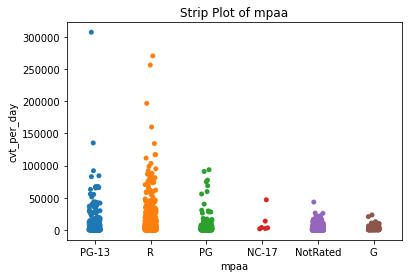

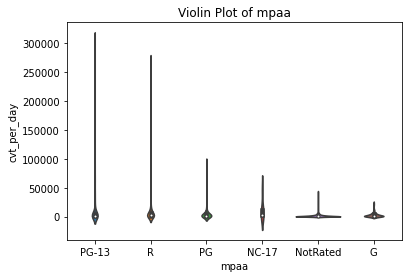

Counts of Each Sub-type in mpaa
NotRated    2158
R           1158
PG-13        426
PG           353
G            125
NC-17          6
Name: mpaa, dtype: int64
Percentages of Each Sub-type in mpaa
NotRated   0.51065
R          0.27402
PG-13      0.10080
PG         0.08353
G          0.02958
NC-17      0.00142
Name: mpaa, dtype: float64


In [ ]:
# Check for mpaa
sns.stripplot(x = 'mpaa', y = 'cvt_per_day', data = cat_ft, jitter = True)
plt.title("Strip Plot of mpaa")
plt.show()

print(" ")

sns.violinplot(x = 'mpaa', y = 'cvt_per_day', data = cat_ft)
plt.title("Violin Plot of mpaa")
plt.show()

print('=================================')
print('Counts of Each Sub-type in mpaa')
print(cat_ft['mpaa'].value_counts())
print('=================================')
print('Percentages of Each Sub-type in mpaa')
print(cat_ft['mpaa'].value_counts()/cat_ft.shape[0])
print('=================================')

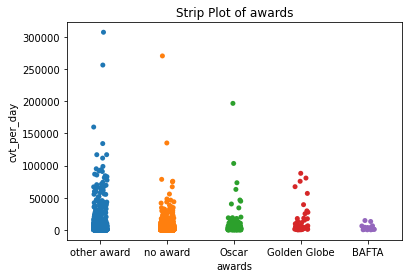

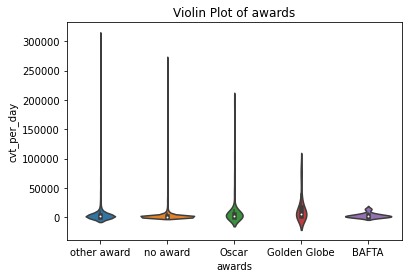

Counts of Each Sub-type in awards
no award        2569
other award     1453
Oscar            141
Golden Globe      44
BAFTA             19
Name: awards, dtype: int64
Percentages of Each Sub-type in awards
no award       0.60790
other award    0.34382
Oscar          0.03336
Golden Globe   0.01041
BAFTA          0.00450
Name: awards, dtype: float64


In [ ]:
# Check for awards
sns.stripplot(x = 'awards', y = 'cvt_per_day', data = cat_ft, jitter = True)
plt.title("Strip Plot of awards")
plt.show()

print(" ")

sns.violinplot(x = 'awards', y = 'cvt_per_day', data = cat_ft)
plt.title("Violin Plot of awards")
plt.show()

print('=================================')
print('Counts of Each Sub-type in awards')
print(cat_ft['awards'].value_counts())
print('=================================')
print('Percentages of Each Sub-type in awards')
print(cat_ft['awards'].value_counts()/cat_ft.shape[0])
print('=================================')


From the plots above, it seems that most of the data point are skewed and clustered at 0.

                   genres  counts
0                   Drama    1677
1                  Comedy    1184
2                Thriller     879
3                  Horror     762
4                  Action     739
5             Documentary     671
6                 Romance     591
7                   Crime     437
8             Independent     393
9                 Mystery     375
10              Adventure     363
11                 Sci-Fi     363
12          Kids & Family     280
13                Fantasy     243
14                  Music     171
15              Animation     129
16                    War     102
17                Western     102
18                  Sport      77
19               Musicals      68
20  Foreign/International      64
21                  Anime      11
22                Reality       9
23              Lifestyle       7
24                  Adult       3
25                   LGBT       2
26                Holiday       1


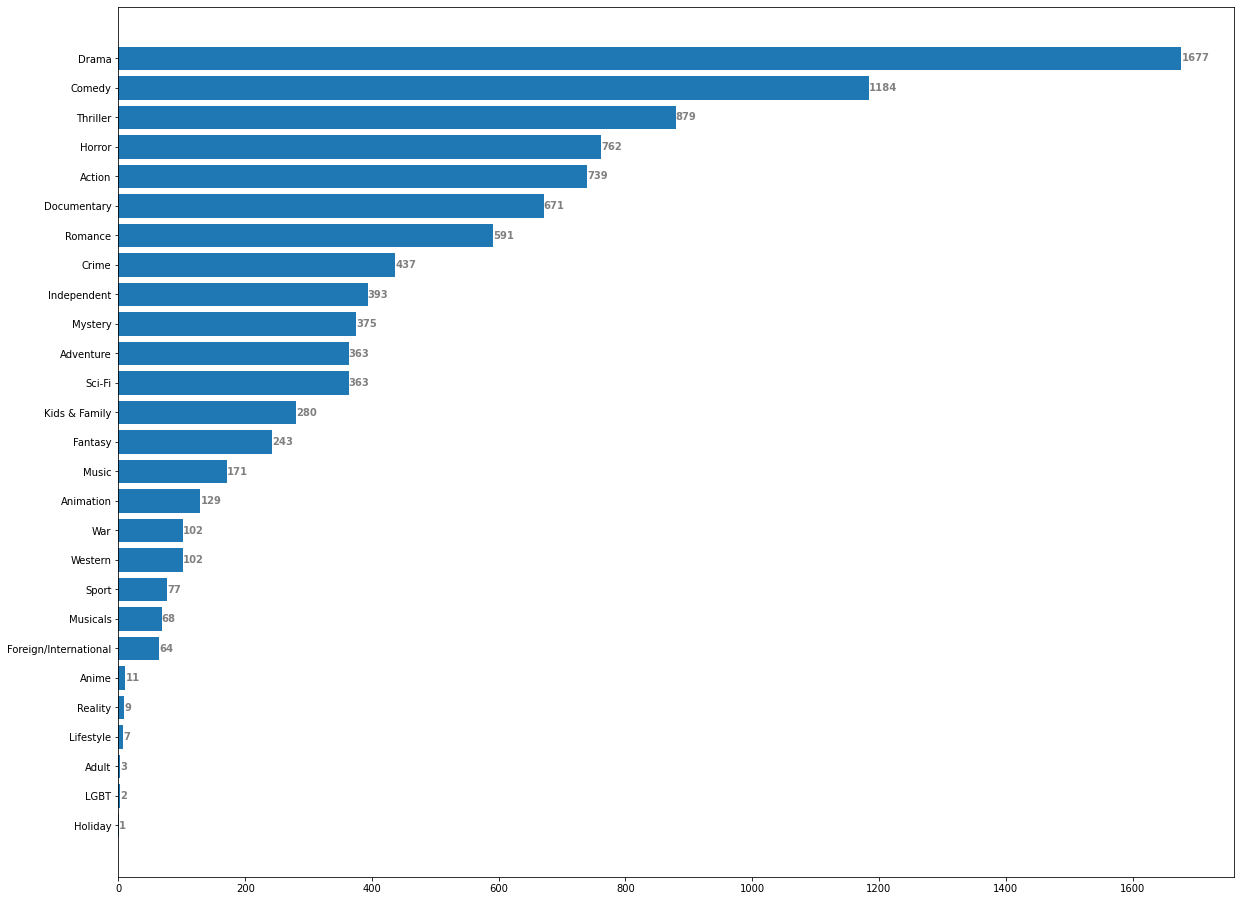

In [ ]:
# genres
gen_split = cat_ft['genres'].str.get_dummies(sep = ',').sum()

gen_df = gen_split.to_frame()
gen_df.reset_index(inplace = True)
gen_df.rename(columns = {'index': 'genres', 0: 'counts'}, inplace = True)

gen_sorted = gen_df.sort_values(by = ['counts'], ascending = False).reset_index(drop = True)

# Print Sorted
print(gen_sorted)

genres = gen_sorted['genres']
counts = gen_sorted['counts']

# Figure Size
fig, ax = plt.subplots(figsize = (20, 16))

# Horizontal Bar Plot
ax.barh(genres, counts)

# Descending Order
ax.invert_yaxis()

# Add Annotation
for i in ax.patches:
  plt.text(i.get_width() + 0.2, i.get_y() + 0.5, 
           str(round((i.get_width()), 2)), fontsize = 10, 
           fontweight = 'bold', color = 'grey')



There are total 27 different sub-types in geres. Notice that there are fewer than 12 counts in 'Anime', 'Reality', 'Lifestyle', 'Adult', 'LGBT', and 'Holiday'.

# Part 2. Data Preprocessing

## 2.1 Numerical Features

There are 10 numerical explanatory variables, excluding 'video_id' and 'release_year': 'weighted_categorical_position', 'weighted_horizontal_position', 'import_id', 'imdb_votes', 'budget', 'boxoffice', 'imdb_rating', 'duration_in_mins', 'metacritic_score', and 'star_category'.

### 2.1.1 Imputation on Missing Data

Although that the dataset does not contain any null values, but it is also important to check possible missing values such as 0. Among these features, there are 4 features which have over 25% of 0 values: 'budget' (58.1%), 'boxoffice' (75.6%), 'metacritic_score' (71.3%) and 'star_category' (43.7%); and there are 2 features which have less than 10% of 0 values: 'imdb_votes' (8.1%) and 'imdb_rating' (8.1%). These 0 values are considered missing values and further investigation is needed. In total, there are 3242 data points which have at least one missing data.

In [ ]:
# Replace 0 values by NA 
TV_file[['budget', 'boxoffice', 'metacritic_score', 'star_category', 'imdb_votes', 'imdb_rating']] = TV_file[['budget', 'boxoffice', 'metacritic_score', 'star_category', 'imdb_votes', 'imdb_rating']].replace(0, np.nan)
print(TV_file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_position   4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     3882 non-null   float64
 8   budget                         1772 non-null   float64
 9   boxoffice                      1032 non-null   float64
 10  imdb_rating                    3882 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               1214 non-null   f

In [ ]:
# Replace NA by mean
TV_1 = TV_file.copy()
TV_1['imdb_votes'] = TV_1['imdb_votes'].fillna(TV_1['imdb_votes'].mean())
TV_1['budget'] = TV_1['budget'].fillna(TV_1['budget'].mean())
TV_1['boxoffice'] = TV_1['boxoffice'].fillna(TV_1['boxoffice'].mean())
TV_1['imdb_rating'] = TV_1['imdb_rating'].fillna(TV_1['imdb_rating'].mean())
TV_1['metacritic_score'] = TV_1['metacritic_score'].fillna(TV_1['metacritic_score'].mean())
TV_1['star_category'] = TV_1['star_category'].fillna(TV_1['star_category'].mean())
print(TV_1.info())
type(TV_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_position   4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   float64
 8   budget                         4226 non-null   float64
 9   boxoffice                      4226 non-null   float64
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   f

pandas.core.frame.DataFrame

### 2.1.2 Feature Scaling

'import_id' is not included in feature scaling process because it does not contain useful information in this case.

In [ ]:
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_position', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']

TV_1[scale_lst].describe()

,weighted_categorical_position,weighted_horizontal_position,budget,boxoffice,imdb_votes,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000,4226.00000
mean,7.78254,28.10364,5129256.08070,10386207.73353,7035.63035,5.72295,89.55612,55.60544,1.69511
std,6.13418,11.86365,6715364.41054,6931155.93622,31537.36533,1.43412,21.08618,7.31418,0.45284
min,1.00000,1.00000,1.00000,1316.00000,5.00000,1.00000,4.03725,1.00000,1.00000
25%,4.00000,20.00000,1500000.00000,10386207.73353,165.00000,4.90000,82.60171,55.60544,1.57500
50%,6.00000,28.00000,5129256.08070,10386207.73353,871.00000,5.80000,90.73031,55.60544,1.69511
75%,9.00000,36.00000,5129256.08070,10386207.73353,5753.25000,6.80000,99.50031,55.60544,1.69511
max,41.00000,70.00000,107000000.00000,184208848.00000,948630.00000,10.00000,246.01677,100.00000,4.00000


The ranges for numerical features are following: 'weighted_categorical_position': 1.000 - 41.000; 'weighted_horizontal_position': 1.000 - 70.000; 'budget': 1.000 - 107,000,000.000; 'boxoffice': 1,316.000 - 184,208,848.000; 'imdb_votes': 5.000 - 948,630.000; 'imdb_rating': 1.000 - 10.000; 'duration_in_min': 4.037 - 246.017; 'metacritic_score': 1.000 - 100.000; 'star_category': 1.000 - 4.000. 


Because machine learning algorithm is not able to distinguish units, magnitudes, and range of numerical features, the it makes the underlying assumption that higher ranging features have superiority than others, and these more significant numbers starts playing a more decisive role while training the model. Therefore, feature scaling is needed to bring every feature in the same footing without any upfront importance. 


Notice that the ranges of numerical feature vary obviously. In order to eliminate the superiority and significance of larger-range numerical variables, feature scaling is applied in preprocessing of data.


There are two common way of feature scaling: Standard Scaling and Min Max Scaling.

In [ ]:
# Standard Scaling
TV_2 = TV_1.copy()
sc_scale = preprocessing.StandardScaler().fit(TV_2[scale_lst])
TV_2[scale_lst] = sc_scale.transform(TV_2[scale_lst])
TV_2.head()


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.60561,-1.10583,-2.11626,lionsgate,2013,"Action,Thriller,Drama",1.98450,1.47005,4.69591,0.54189,1.07879,-0.62973,other award,PG-13,0.03289
1,300175,270338.42637,-1.10583,-2.11626,lionsgate,2013,"Comedy,Crime,Thriller",1.25800,1.47005,-1.02234,0.54189,0.25741,-1.99710,no award,R,3.43403
2,361899,256165.86745,-1.10583,-2.11626,other,2012,"Crime,Drama",6.04308,3.10828,3.89751,1.09979,1.24303,0.32743,other award,R,2.10155
3,308314,196622.72100,-0.77975,-2.03196,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",11.07717,1.47005,0.76674,1.30900,1.95163,5.24995,Oscar,R,-0.06281
4,307201,159841.65206,-1.10583,-2.11626,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",1.25848,3.28997,-0.26478,0.47216,0.75838,-2.54405,other award,R,3.02913


In [ ]:
# Min Max Scaling
# TV_mm = TV_1.copy()
# mm_scale = preprocessing.MinMaxScaler().fit(TV_mm[scale_lst])
# TV_mm[scale_lst] = mm_scale.transform(TV_mm[scale_lst])

## 2.2 Categorical Features

In this dataset, there are 5 categorical features: 'import_id', 'mpaa', 'awards', 'genres', and 'release_year'. There are no missing values in these categorical features. They can be converted into dummy/indicators.

'import_id', 'mpaa', and 'awards' have small sub-types, so they can be easily converted to dummies.

In [ ]:
# import_id
d_import_id = pd.get_dummies(TV_2['import_id'])
# mpaa
d_mpaa = pd.get_dummies(TV_2['mpaa'])
# awards
d_awards = pd.get_dummies(TV_2['awards'])

The 'genres' variable has 27 different sub-types, and 6 ('Anime', 'Reality', 'Lifestyle','Adult', 'LGBT', 'Holiday') of them are rarely observed. Therefore, they are grouped into one sub-type. Because a video may have more than one genre, in the feature preprocessing, all genres are handled individually.

In [ ]:
d_genres = TV_2['genres'].str.get_dummies(sep = ',')
d_genres['Others'] = d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality', 'Lifestyle','Adult', 'LGBT', 'Holiday'], inplace = True, axis = 1)

The 'release_year' variable is binned into 10 buckets based on the year range between 1917 and 2017.

In [ ]:
TV_2['release_year'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

0.10000   1974.00000
0.20000   1991.00000
0.30000   2001.00000
0.40000   2006.00000
0.50000   2008.00000
0.60000   2010.00000
0.70000   2012.00000
0.80000   2013.00000
0.90000   2014.00000
Name: release_year, dtype: float64

In [ ]:
# bin release_year and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014, 2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008', 
              '2008-2010','2010-2012', '2012-2013','2013-2014','2014-2017']

year_bin = pd.cut(TV_2['release_year'], bin_year, labels = year_range)
d_year = pd.get_dummies(year_bin)

In [ ]:
temp_tv = TV_2.drop(['import_id', 'mpaa', 'awards', 'genres', 'release_year'], axis = 1)
TV_final = pd.concat([temp_tv, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis = 1)
TV_final.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Others,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.984,1.470,4.696,0.542,1.079,-0.630,0.033,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.258,1.470,-1.022,0.542,0.257,-1.997,3.434,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.043,3.108,3.898,1.100,1.243,0.327,2.102,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.077,1.470,0.767,1.309,1.952,5.250,-0.063,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.258,3.290,-0.265,0.472,0.758,-2.544,3.029,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
TV_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   float64
 3   weighted_horizontal_position   4226 non-null   float64
 4   imdb_votes                     4226 non-null   float64
 5   budget                         4226 non-null   float64
 6   boxoffice                      4226 non-null   float64
 7   imdb_rating                    4226 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   metacritic_score               4226 non-null   float64
 10  star_category                  4226 non-null   float64
 11  lionsgate                      4226 non-null   uint8  
 12  mgm                            4226 non-null   u

# Part 3. Model Training

In [ ]:
train, test = train_test_split(TV_final, test_size=0.15, random_state = 3)

model_train_x = train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = test.drop(['video_id', 'cvt_per_day'], axis = 1)

model_train_y = train['cvt_per_day']
model_test_y = test['cvt_per_day']

print('Training data has ' + str(model_train_x.shape[0]) + ' observation with ' + str(model_train_x.shape[1]) + ' features.')
print('Test data has ' + str(model_test_x.shape[0]) + ' observation with ' + str(model_test_x.shape[1]) + ' features.')

Training data has 3592 observation with 56 features.
Test data has 634 observation with 56 features.


In [ ]:
lr_train, lr_validate = train_test_split(train, test_size = 0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

print('Training data has ' + str(lr_train_x.shape[0]) + ' observation with ' + str(lr_train_x.shape[1]) + ' features.')
print('Validate data has ' + str(lr_validate_x.shape[0]) + ' observation with ' + str(lr_validate_x.shape[1]) + ' features.')

Training data has 3053 observation with 56 features.
Validate data has 539 observation with 56 features.


## 3.1 Lasso Linear Regression

In [ ]:
alphas1 = np.linspace (1, 201, num = 500)
scores1 = np.empty_like(alphas1)
opt_a1 = float('-inf')
max_score1 = float('-inf')

In [ ]:
for i, a in enumerate(alphas1):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores1[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores1[i] > max_score1:
        max_score1 = scores1[i]
        opt_a1 = a
        lasso_save1 = lasso #optional code

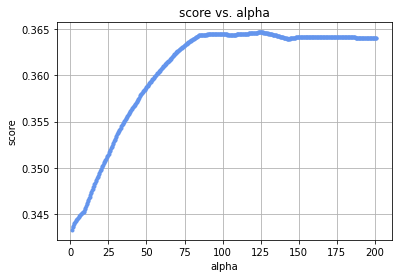

The optimized alpha of Lasso Linear Mode is  125.64929859719439
The optimized score of Lasso Linear Mode is  0.3646194368519905


In [ ]:
plt.plot(alphas1, scores1, color = 'cornflowerblue', linestyle = 'dashed', marker = 'o',markerfacecolor = 'cornflowerblue', markersize = 3)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()

model1_para = opt_a1
print('The optimized alpha of Lasso Linear Mode is ', opt_a1)
print('The optimized score of Lasso Linear Mode is ', max_score1)

In [ ]:
# use optimized alpha given above to retrain the data with both traning data and validate data
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a1)
lasso_f.fit(model_train_x, model_train_y)

Lasso(alpha=125.64929859719439)

## 3.2 Ridge Linear Regression

In [ ]:
alphas2 = np.linspace (1, 201, num = 500)
scores2 = np.empty_like(alphas2)
opt_a2 = float('-inf')
max_score2 = float('-inf')

In [ ]:
for i, a in enumerate(alphas2):
  ridge = Ridge()
  ridge.set_params(alpha = a)
  ridge.fit(lr_train_x, lr_train_y)
  scores2[i] = ridge.score(lr_validate_x, lr_validate_y)
  if scores2[i] > max_score2:
    max_score2 = scores2[i]
    opt_a2 = a
    ridge_save2 = ridge

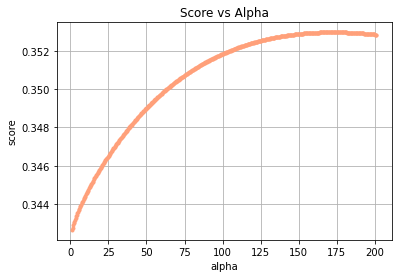

The optimized alpha of Ridge Linear Mode is  172.5430861723447
The optimized score of Ridge Linear Mode is  0.3529726994066543


In [ ]:
plt.plot(alphas2, scores2, color = 'lightsalmon', linestyle = 'dashed', marker = 'o', markerfacecolor = 'lightsalmon', markersize = 3)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('Score vs Alpha')
plt.show()

model2_para = opt_a2
print('The optimized alpha of Ridge Linear Mode is ', opt_a2)
print('The optimized score of Ridge Linear Mode is ', max_score2)

In [ ]:
# use optimized alpha given above to retrain the data with both traning data and validate data
ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a2)
ridge_f.fit(model_train_x, model_train_y)

Ridge(alpha=172.5430861723447)

## 3.3 Random Forest Regression

In [ ]:
rf = RandomForestRegressor(random_state = 2, max_features = 'sqrt')
param_grid = {'n_estimators': [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], 'max_depth': [15, 16, 17, 28, 19, 20, 21, 22]}
clf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
clf.fit(model_train_x, model_train_y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=2),
             param_grid={'max_depth': [15, 16, 17, 28, 19, 20, 21, 22],
                         'n_estimators': [55, 56, 57, 58, 59, 60, 61, 62, 63,
                                          64, 65]})

In [ ]:
rst = clf.cv_results_
print(rst)

{'mean_fit_time': array([0.24208355, 0.23912134, 0.2448339 , 0.25159245, 0.25549574,
       0.25639248, 0.26284957, 0.26556168, 0.26902199, 0.27718968,
       0.27529278, 0.25207548, 0.25193763, 0.25694118, 0.26625328,
       0.2655839 , 0.26954536, 0.2739552 , 0.27928882, 0.28205562,
       0.2843329 , 0.29086108, 0.26001844, 0.26340895, 0.26979079,
       0.27645125, 0.28100867, 0.28376532, 0.28841448, 0.29229536,
       0.29769559, 0.30170679, 0.30624056, 0.30845966, 0.32011385,
       0.32415419, 0.32626882, 0.33296657, 0.34098806, 0.34301076,
       0.34641256, 0.35936999, 0.3638886 , 0.3668551 , 0.27615499,
       0.28320823, 0.28383861, 0.28802719, 0.2946887 , 0.30033746,
       0.30678191, 0.3113277 , 0.3180809 , 0.31904945, 0.32153058,
       0.28328385, 0.29033523, 0.29335785, 0.296242  , 0.29928102,
       0.30865254, 0.31435642, 0.32142706, 0.32230673, 0.32673841,
       0.33139682, 0.28789678, 0.29630857, 0.30047216, 0.30183091,
       0.31367083, 0.31512756, 0.32137265, 0

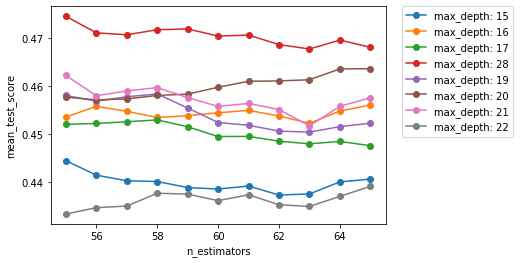

The best parameter for max_depth is : 28
The best parameter for n_estimators is: 55


In [ ]:
max_depth = [15, 16, 17, 28, 19, 20, 21, 22]
n_estimators = [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
scores = clf.cv_results_['mean_test_score'].reshape(len(max_depth), len(n_estimators))
plt.figure(1)
plt.subplot(1, 1, 1)

for i, j in enumerate(max_depth):
  plt.plot(n_estimators, scores[i], '-o', label = 'max_depth: ' + str(j))

plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()

print('The best parameter for max_depth is : ' + str(clf.best_params_['max_depth']))
print('The best parameter for n_estimators is: ' + str(clf.best_params_['n_estimators']))

# Part 4. Model Evaluation

## 4.1 Evaluate All Models

In [ ]:
x_train, x_test, y_train, y_test = model_train_x, model_test_x, model_train_y, model_test_y

In [ ]:
# Lasso Linear Regression
lasso = Lasso(alpha = model1_para)
lasso.fit(x_train, y_train)
pred_lasso_y = lasso.predict(x_test)
lasso_score = lasso.score(x_test, y_test)
MSE_lasso = mean_squared_error(y_test, pred_lasso_y)
RMSE_lasso = np.sqrt(MSE_lasso)

print('Lasso score: ', lasso_score)
print('Mean Square Error of Lasso: ', MSE_lasso)
print('Root Mean Squared Error of Lasso: ', RMSE_lasso)

Lasso score:  0.09898048413763116
Mean Square Error of Lasso:  239104131.54554778
Root Mean Squared Error of Lasso:  15462.99232184857


In [ ]:
# Ridge Linear Regression
ridge = Ridge(alpha = model2_para)
ridge.fit(x_train, y_train)
pred_ridge_y = ridge.predict(x_test)
ridge_score = ridge.score(x_test, y_test)
MSE_ridge = mean_squared_error(y_test, pred_ridge_y)
RMSE_ridge = np.sqrt(MSE_ridge)

print('Ridge score: ', ridge_score)
print('Mean Square Error of Ridge: ', MSE_ridge)
print('Root Mean Squared Error of Ridge: ', RMSE_ridge)

Ridge score:  0.1138238752321652
Mean Square Error of Ridge:  235165131.2526933
Root Mean Squared Error of Ridge:  15335.094758516925


In [ ]:
# Random Forest Regression
rf = RandomForestRegressor(n_estimators = clf.best_params_['n_estimators'], max_depth = clf.best_params_['max_depth'], max_features = 'sqrt', random_state = 2, n_jobs = -1)
rf.fit(x_train, y_train)
pred_rf_y = rf.predict(x_test)
rf_score = rf.score(x_test, y_test)
MSE_rf = mean_squared_error(y_test, pred_rf_y)
RMSE_rf = np.sqrt(MSE_rf)

print('Random Forest score: ', rf_score)
print('Mean Square Error of Random Forest: ', MSE_rf)
print('Root Mean Squared Error of Random Forest: ', RMSE_rf)

Random Forest score:  0.5080172553188199
Mean Square Error of Random Forest:  130557779.08406298
Root Mean Squared Error of Random Forest:  11426.188300744172


## 4.2 Model Comparison

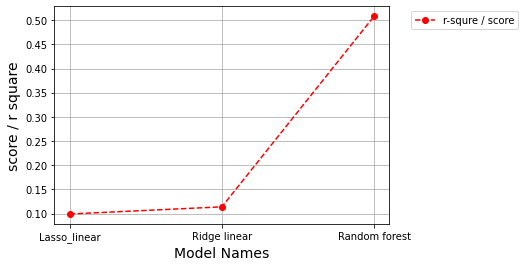

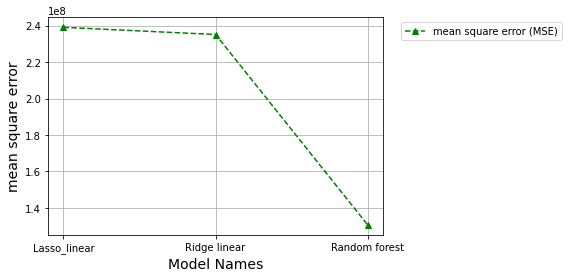

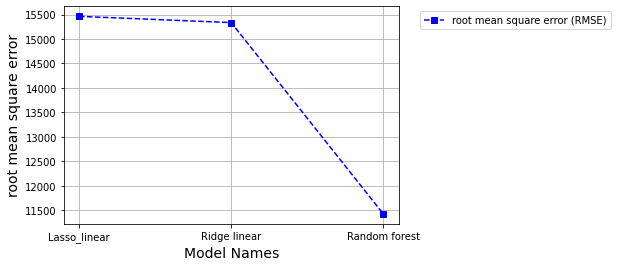

In [ ]:
lst_score = [lasso_score, ridge_score, rf_score]
MSE_lst =  [MSE_lasso, MSE_ridge, MSE_rf]
RMSE_lst =  [RMSE_lasso, RMSE_ridge, RMSE_rf]
model_lst = ['Lasso_linear', 'Ridge linear', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro--')
plt.legend(['r-squre / score'], bbox_to_anchor = (1.05, 1))
plt.xlabel('Model Names',fontsize = 14)
plt.ylabel('score / r square', fontsize = 14)
plt.grid(True)
plt.show()

print(" ")

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^--')
plt.legend(['mean square error (MSE)'], bbox_to_anchor = (1.55, 1))
plt.xlabel('Model Names', fontsize = 14)
plt.ylabel('mean square error', fontsize = 14)
plt.grid(True)
plt.show()

print(" ")

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs--')
plt.legend(['root mean square error (RMSE)'], bbox_to_anchor = (1.05, 1))
plt.xlabel('Model Names', fontsize = 14)
plt.ylabel('root mean square error', fontsize =14)
plt.grid(True)
plt.show()

## 4.3 Feature Importance

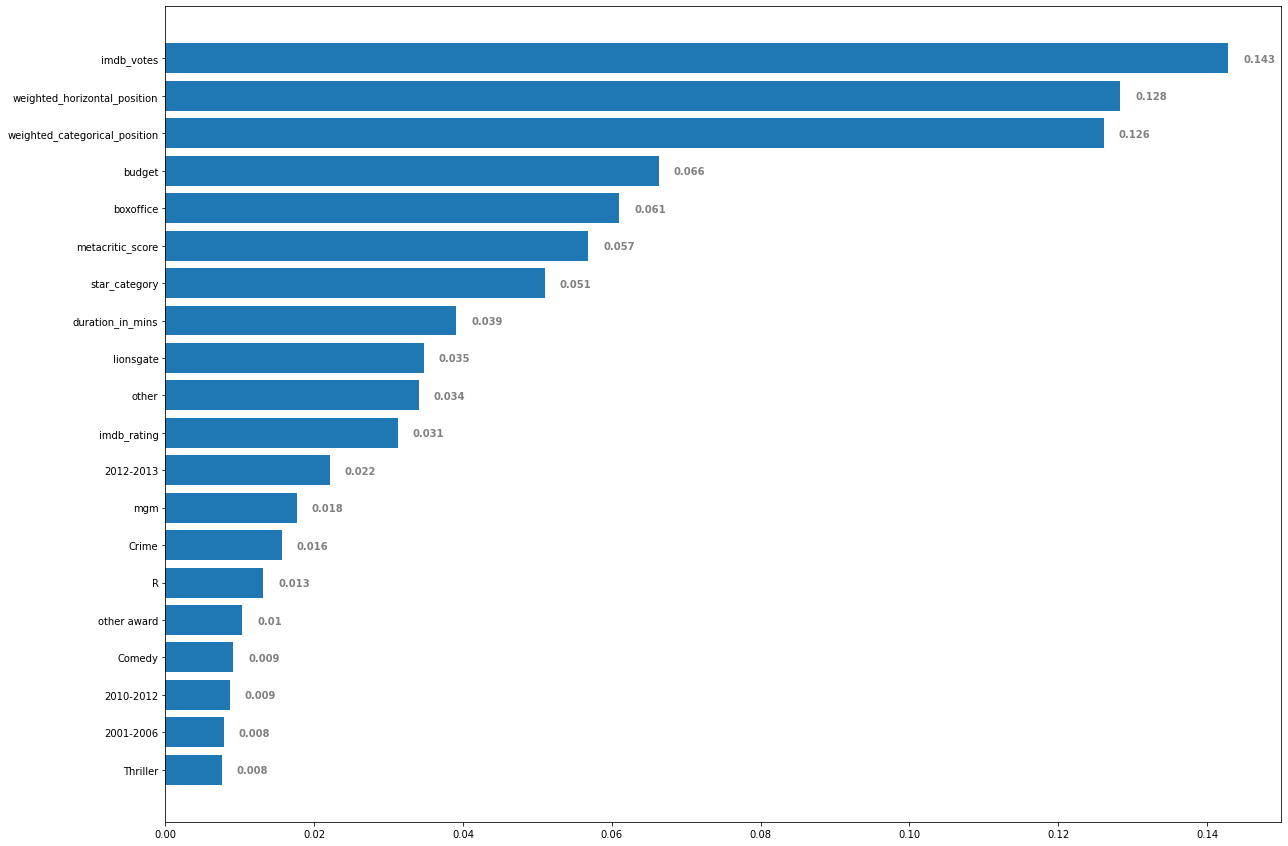

In [ ]:
importances = rf.feature_importances_
feature_name = x_train.columns.values

df = {'importances': importances, 'feature_name': feature_name}

feature_imp = pd.DataFrame(data = df)
feature_imp_sorted = feature_imp.sort_values(by = ['importances'], ascending = False)

ft = feature_imp_sorted['feature_name'][:20]
imp = feature_imp_sorted['importances'][:20]

# Figure Size
fig, ax = plt.subplots(figsize = (20, 15))

# Horizontal Bar Plot
ax.barh(ft, imp)

# Descending Order
ax.invert_yaxis()

# Add Annotation
for i in ax.patches:
  plt.text(i.get_width() + 0.002, i.get_y() + 0.5, 
           str(round((i.get_width()), 3)), fontsize = 10, 
           fontweight = 'bold', color = 'grey')